# Import required Libraries


In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("Agg")

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)
from tensorflow.keras.layers import (Dense, Lambda, Dropout, Activation)

from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


2024-06-29 10:33:48.137639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 10:33:48.137780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 10:33:48.284503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## check for GPU availability

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

## Reading Data 

In [4]:
df = pd.read_csv(STYLES_CSV_PATH,  on_bad_lines='skip')
print(f"Total Rows: {df.shape[0]}\nTotal Columns: {df.shape[1]}")
df.head()

Total Rows: 44424
Total Columns: 10


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


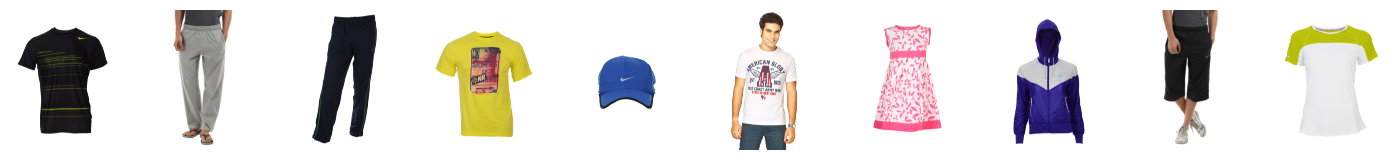

In [5]:
import pathlib
import matplotlib.image as mpimg
path = '../input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/'
plt.figure(figsize=(20,20))
for i in range(10, 20):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100'+ str(i) +'.jpg')
    plt.imshow(cloth_img)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

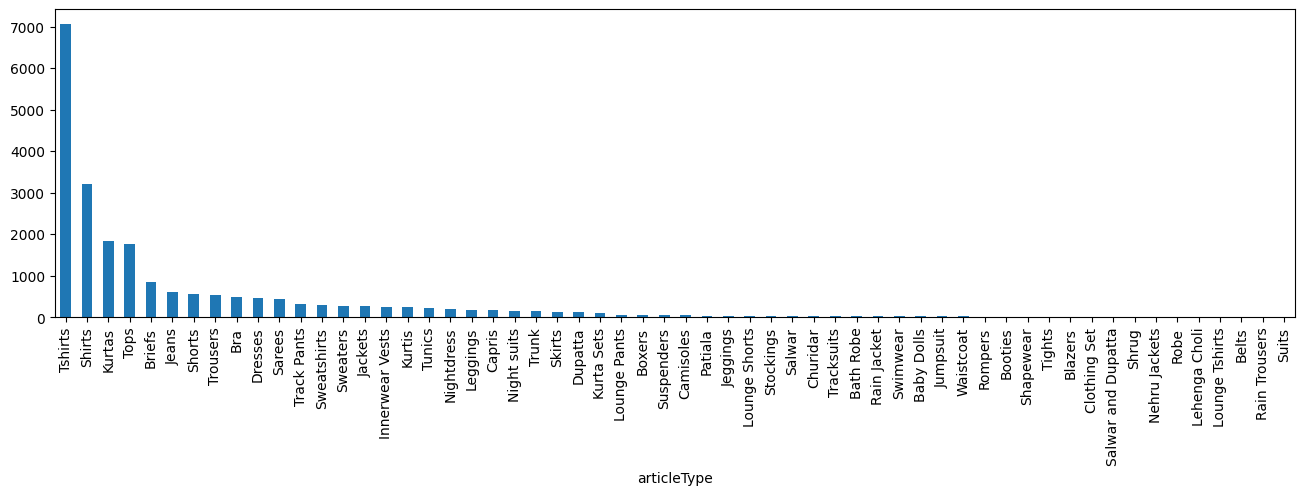

In [6]:
plt.figure(figsize=(16, 4))
sub = df[df["masterCategory"]=="Apparel"] # we could only consider "Appeal" masterCategory for now
sub["articleType"].value_counts(sort=True).plot(kind="bar")
plt.show()

In [7]:
print('NaN Count:')
df.isna().sum()

NaN Count:


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [8]:
df = df.dropna()
df = df.drop(['year', 'productDisplayName', 'masterCategory', 'subCategory','usage'], axis=1)
# df = df.sample(1000)
df = df[df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]

In [9]:
df['id'] = df['id'].apply(lambda x: IMAGES_PATH+str(x) +'.jpg')
image_ids = df.pop('id')

In [10]:
def bin_values(x):
    x_vc = df[x].value_counts()
    x_other = x_vc[x_vc<50].index
    df.loc[df[x].isin(x_other),x] = 'Other'
    
for col in df.columns:
    bin_values(col)

In [11]:
from keras.applications.resnet import preprocess_input

IMAGE_DIMS = (60, 60, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

image_data = []
for img_path in tqdm(image_ids):
    image_data.append(load_image(img_path))
    
image_data = np.array(image_data, dtype="float")

100%|██████████| 44072/44072 [18:40<00:00, 39.32it/s]


In [12]:
articleTypeLB = LabelBinarizer()
genderLB = LabelBinarizer()
baseColourLB = LabelBinarizer()
seasonLB = LabelBinarizer()

articleTypeLabels = articleTypeLB.fit_transform(np.array(df['articleType'].values))
genderLabels = genderLB.fit_transform(np.array(df['gender'].values))
baseColourLabels = baseColourLB.fit_transform(np.array(df['baseColour'].values))
seasonLabels = seasonLB.fit_transform(np.array(df['season'].values))

split = train_test_split(image_data,
                         articleTypeLabels, 
                         genderLabels, 
                         baseColourLabels, 
                         seasonLabels,
                         test_size=0.2, random_state=42)

(trainX, testX,
 trainArticleTypeY, testArticleTypeY,
 trainGenderY, testGenderY,
 trainBaseColourY, testBaseColourY,
 trainSeasonY, testSeasonY) = split

In [13]:
from tensorflow.keras.applications import ResNet50

In [14]:
def make_branch(res_input, n_out, act_type, name):
    z = Dense(512, activation="relu")(res_input)
    z = Dense(256, activation='relu')(z)
    z = Dense(128, activation='relu')(z)
    z = Dense(n_out)(z)
    z = Activation(act_type, name=name+'_output')(z)
    return z

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

def build_model():
    IMAGE_DIMS = (60, 60, 3)  # Example dimensions, update as needed

    # Load EfficientNetB0 with pretrained weights, without the top layers
    effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
    effnet.trainable = False

    # Define the input layer
    inputs = Input(shape=IMAGE_DIMS)

    # Pass the input through the EfficientNetB0 model
    x = effnet(inputs, training=False)

    # Flatten the output of EfficientNetB0
    x = Flatten()(x)

    # Add a fully connected layer
    x = Dense(1024, activation='relu')(x)

    # Create branches for each output
    article_branch = make_branch(x, len(articleTypeLB.classes_), 'softmax', 'article')
    gender_branch = make_branch(x, len(genderLB.classes_), 'softmax', 'gender')
    color_branch = make_branch(x, len(baseColourLB.classes_), 'softmax', 'color')
    season_branch = make_branch(x, len(seasonLB.classes_), 'softmax', 'season')

    # Create the model
    model = Model(inputs=inputs, outputs=[article_branch, gender_branch, color_branch, season_branch])

    return model


In [17]:
model = build_model()

losses = {
    "article_output": "categorical_crossentropy",
    "gender_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
    "season_output": "categorical_crossentropy",
}

metrics = {
    "article_output": ["accuracy"],
    "gender_output": ["accuracy"],
    "color_output": ["accuracy"],
    "season_output": ["accuracy"],
}

EPOCHS = 50
INIT_LR = 1e-5
BS = 32

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, metrics=metrics)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 60, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 2, 2,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5120)      │          0 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  5,243,904 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 69)        │      8,901 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │        645 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 36)        │      4,644 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 4)         │        516 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ article_output      │ (None, 69)        │          0 │ dense_4[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 5)         │          0 │ dense_8[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ color_output        │ (None, 36)        │          0 │ dense_12[0][0]  

 Total params: 12,064,277 (46.02 MB)

 Trainable params: 8,014,706 (30.57 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

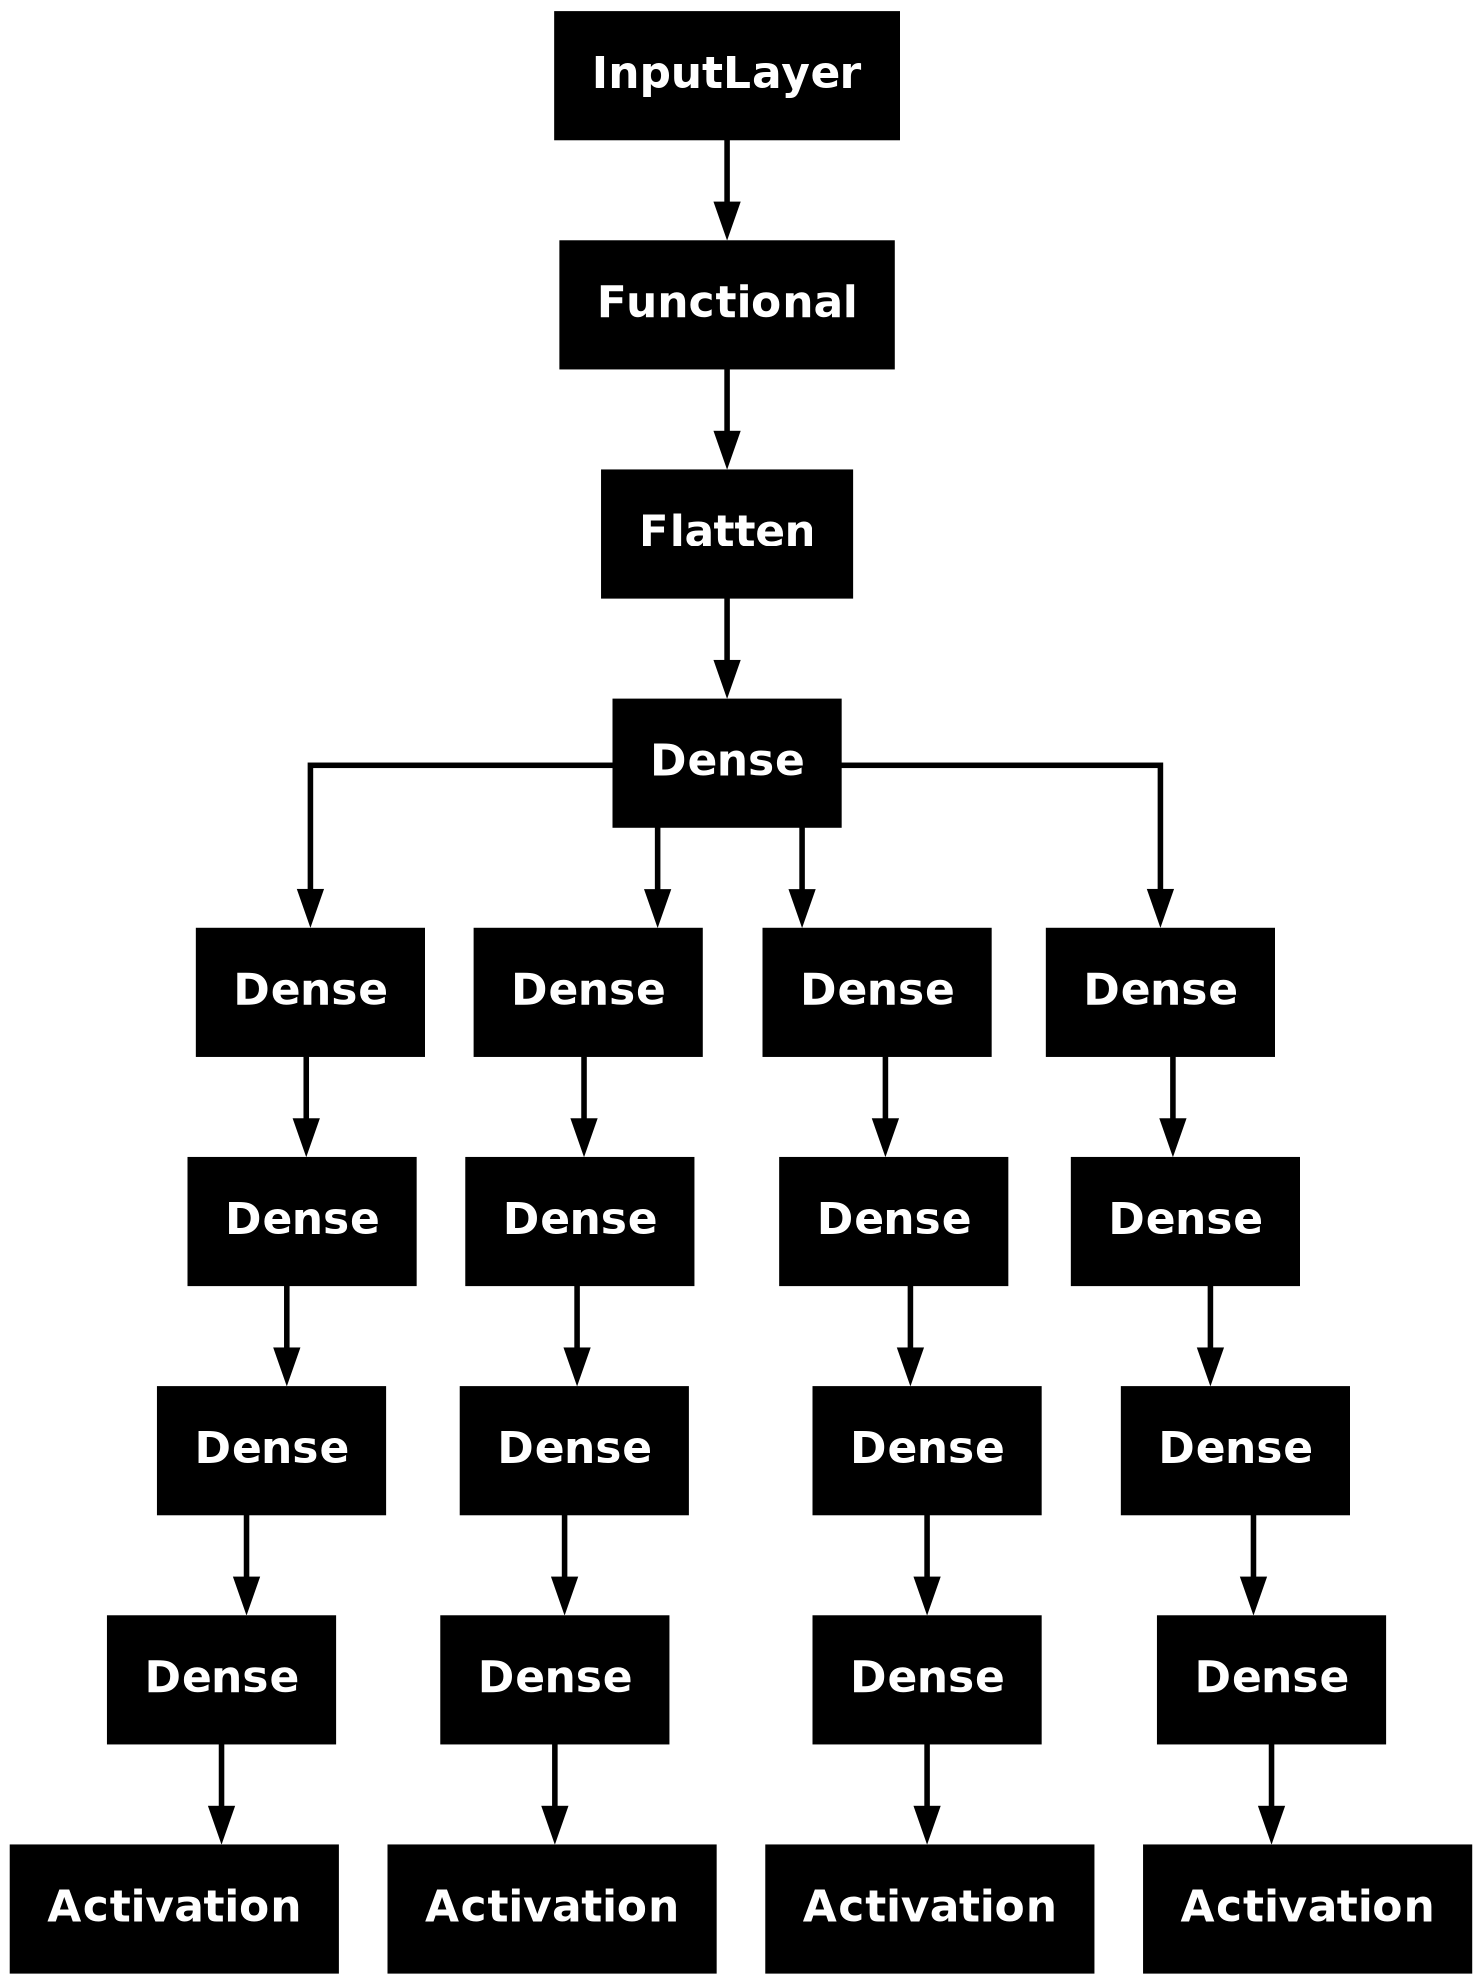

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# Ensure your target arrays are integer-encoded with shape (batch_size,)
print("Target shapes:")
print("trainArticleTypeY shape:", trainArticleTypeY.shape)
print("trainGenderY shape:", trainGenderY.shape)
print("trainBaseColourY shape:", trainBaseColourY.shape)
print("trainSeasonY shape:", trainSeasonY.shape)

# Ensure your model outputs have the correct shape
print("\nModel output shapes:")
predictions = model.predict(trainX[:5])  # Adjust this for a small batch size to check output
print("Output shape for article_output:", predictions[0].shape)
print("Output shape for gender_output:", predictions[1].shape)
print("Output shape for color_output:", predictions[2].shape)
print("Output shape for season_output:", predictions[3].shape)

Target shapes:
trainArticleTypeY shape: (35257, 69)
trainGenderY shape: (35257, 5)
trainBaseColourY shape: (35257, 36)
trainSeasonY shape: (35257, 4)

Model output shapes:
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Output shape for article_output: (5, 69)
Output shape for gender_output: (5, 5)
Output shape for color_output: (5, 36)
Output shape for season_output: (5, 4)


I0000 00:00:1719658381.324322     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719658381.363570     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with early stopping
H = model.fit(trainX,
              {"article_output": trainArticleTypeY,
               "gender_output": trainGenderY,
               "color_output": trainBaseColourY,
               "season_output": trainSeasonY},
              validation_data=(testX,
                               {"article_output": testArticleTypeY,
                                "gender_output": testGenderY,
                                "color_output": testBaseColourY,
                                "season_output": testSeasonY}),
              epochs=EPOCHS,
              batch_size=BS,
              callbacks=[early_stopping],  # Add the early stopping callback here
              verbose=1)

Epoch 1/50
  14/1102 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - article_output_accuracy: 0.0652 - color_output_accuracy: 0.0561 - gender_output_accuracy: 0.2828 - loss: 10.9281 - season_output_accuracy: 0.2265

W0000 00:00:1719658424.627975     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1102/1102 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - article_output_accuracy: 0.2809 - color_output_accuracy: 0.2403 - gender_output_accuracy: 0.6779 - loss: 7.9865 - season_output_accuracy: 0.5077

W0000 00:00:1719658465.056010     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719658472.716433     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719658480.869648     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1102/1102 ━━━━━━━━━━━━━━━━━━━━ 93s 51ms/step - article_output_accuracy: 0.2810 - color_output_accuracy: 0.2404 - gender_output_accuracy: 0.6779 - loss: 7.9852 - season_output_accuracy: 0.5078 - val_article_output_accuracy: 0.6116 - val_color_output_accuracy: 0.4362 - val_gender_output_accuracy: 0.8112 - val_loss: 5.0499 - val_season_output_accuracy: 0.6413
Epoch 2/50
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - article_output_accuracy: 0.6387 - color_output_accuracy: 0.4481 - gender_output_accuracy: 0.8169 - loss: 4.8253 - season_output_accuracy: 0.6483 - val_article_output_accuracy: 0.6876 - val_color_output_accuracy: 0.4775 - val_gender_output_accuracy: 0.8319 - val_loss: 4.3013 - val_season_output_accuracy: 0.6543
Epoch 3/50
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - article_output_accuracy: 0.7028 - color_output_accuracy: 0.4859 - gender_output_accuracy: 0.8414 - loss: 4.1731 - season_output_accuracy: 0.6665 - val_article_output_accuracy: 0.7168 - val_color_output_accuracy: 0

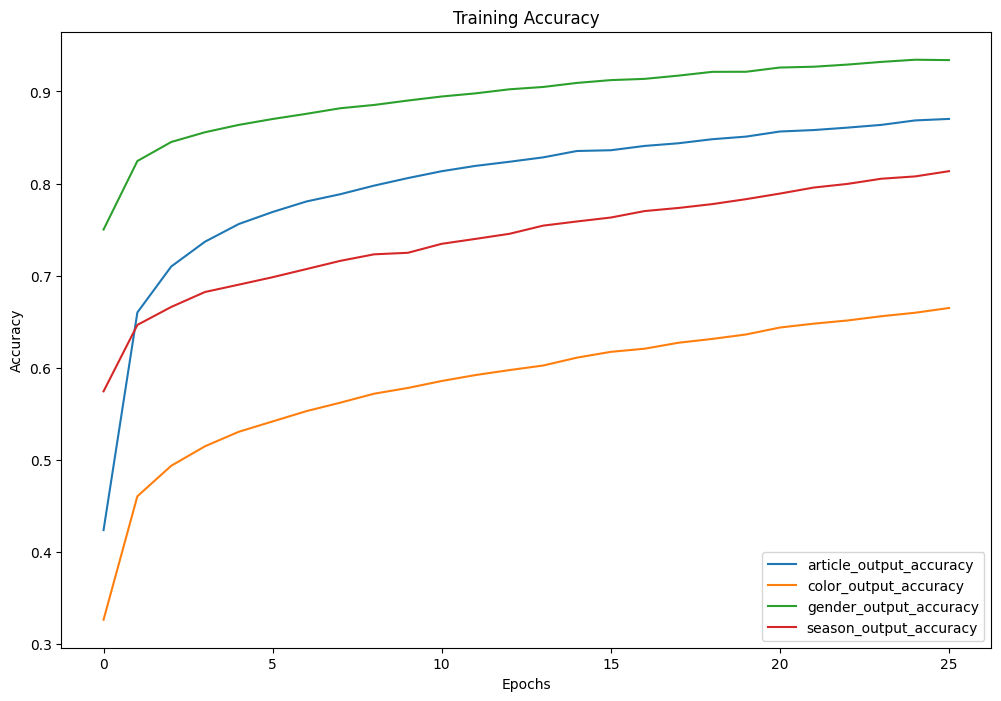

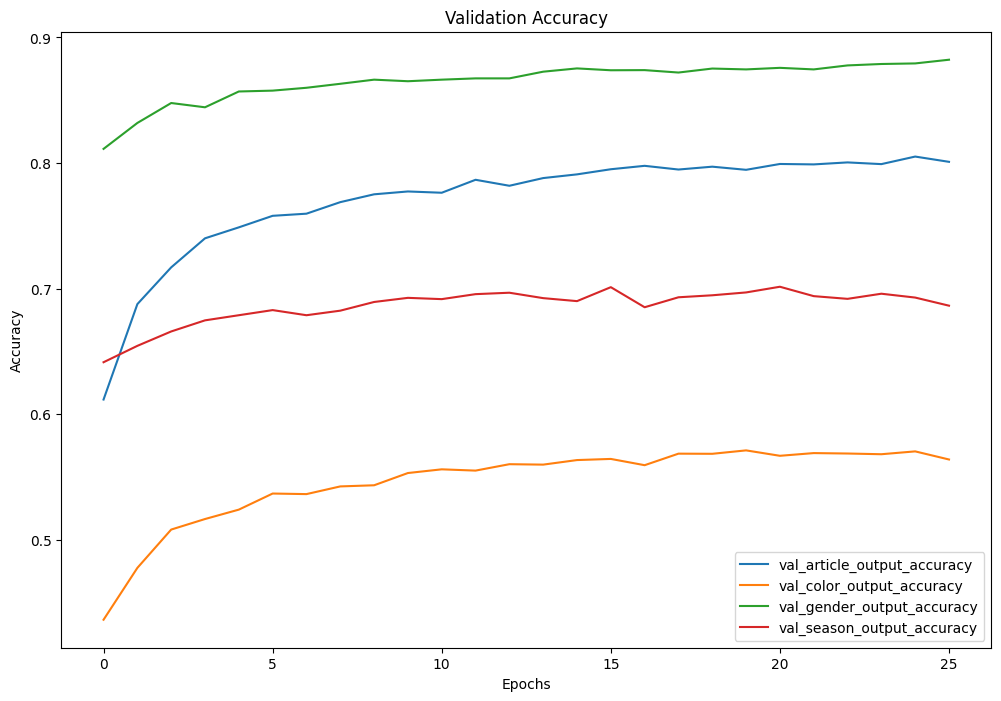

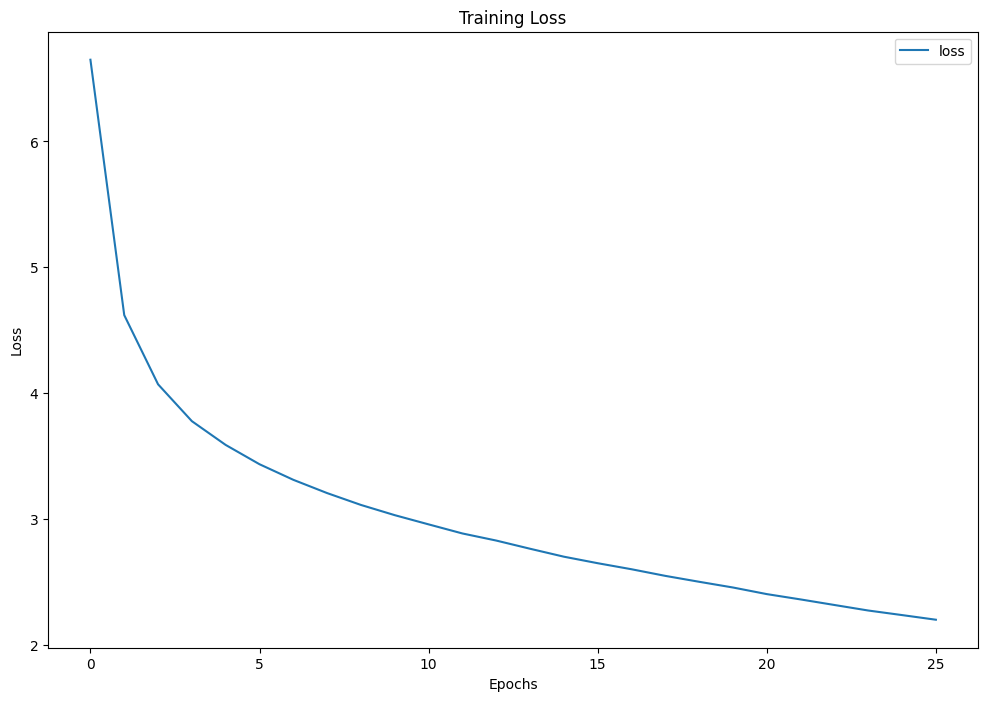

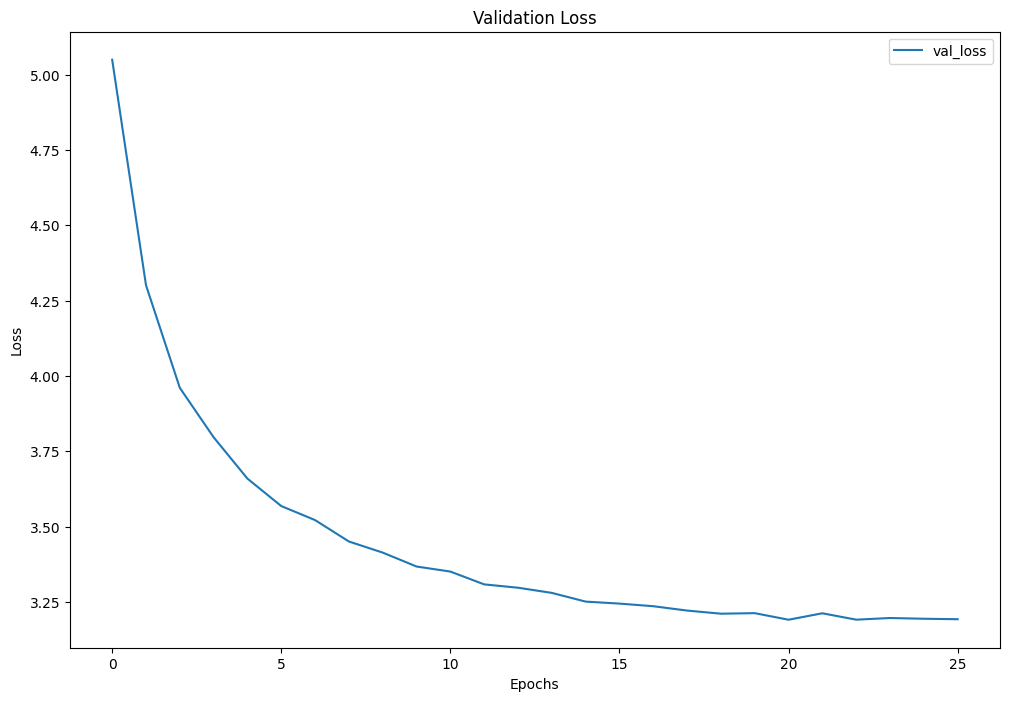

In [22]:
# Assuming H is the history object returned by model.fit()
h_df = pd.DataFrame(H.history)

# Print the DataFrame to verify its contents
# print(h_df)

# Plot training accuracy for each output
train_accuracy_cols = [col for col in h_df.columns if 'accuracy' in col and 'val' not in col]
h_df[train_accuracy_cols].plot(figsize=(12, 8))
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy for each output
val_accuracy_cols = [col for col in h_df.columns if 'accuracy' in col and 'val' in col]
h_df[val_accuracy_cols].plot(figsize=(12, 8))
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot training loss
train_loss_cols = [col for col in h_df.columns if 'loss' in col and 'val' not in col]
h_df[train_loss_cols].plot(figsize=(12, 8))
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Plot validation loss
val_loss_cols = [col for col in h_df.columns if 'loss' in col and 'val' in col]
h_df[val_loss_cols].plot(figsize=(12, 8))
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()


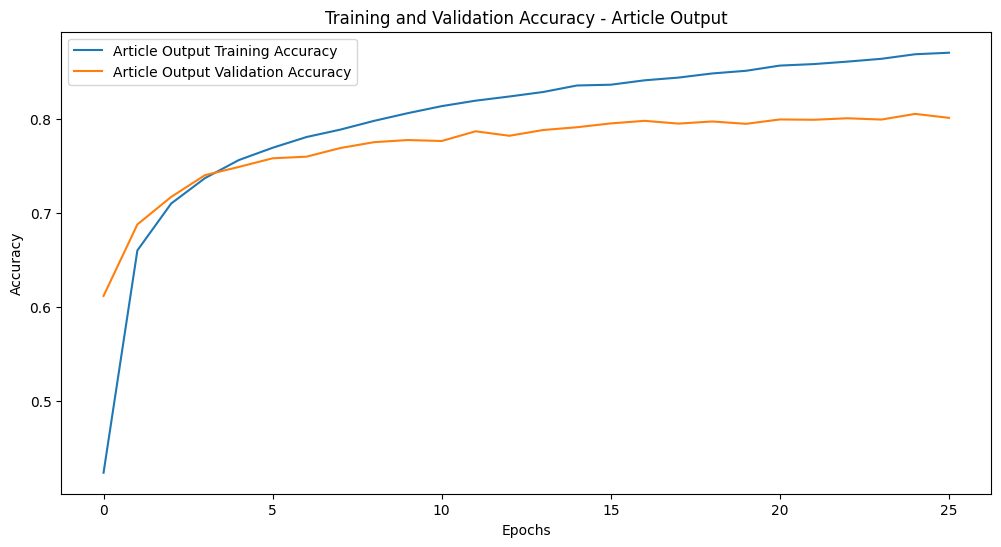

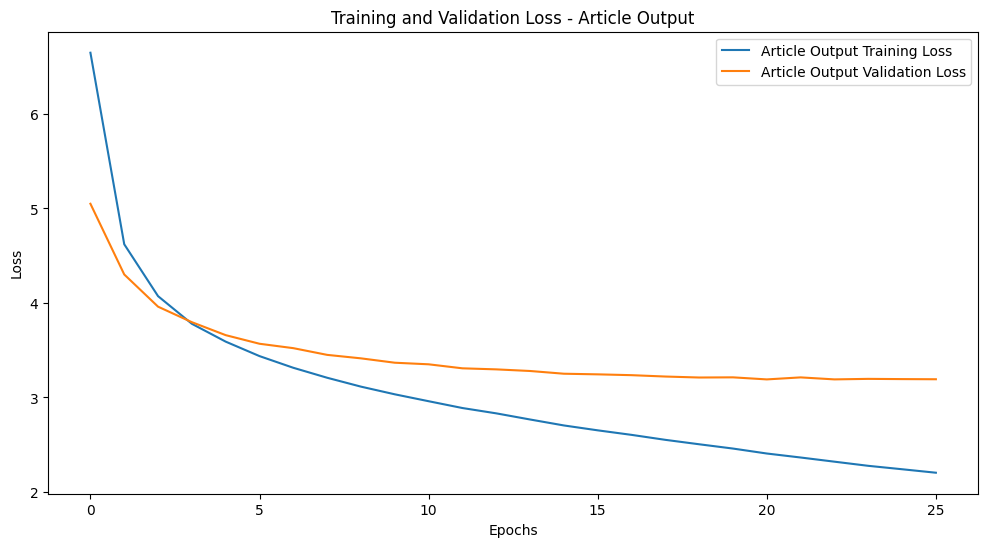

In [23]:
# Assuming H.history is already defined as h_df
h_df = pd.DataFrame(H.history)

# Plot training and validation accuracy for article_output
plt.figure(figsize=(12, 6))
plt.plot(h_df['article_output_accuracy'], label='Article Output Training Accuracy')
plt.plot(h_df['val_article_output_accuracy'], label='Article Output Validation Accuracy')
plt.title('Training and Validation Accuracy - Article Output')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss for article_output
plt.figure(figsize=(12, 6))
plt.plot(h_df['loss'], label='Article Output Training Loss')
plt.plot(h_df['val_loss'], label='Article Output Validation Loss')
plt.title('Training and Validation Loss - Article Output')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Repeat the above for other outputs like color_output, gender_output, season_output, etc.


In [24]:
# Evaluate the model on test data
res = model.evaluate(testX, 
                     {"article_output": testArticleTypeY,
                      "gender_output": testGenderY,
                      "color_output": testBaseColourY,
                      "season_output": testSeasonY}, 
                     batch_size=32, verbose=1)

# Print the complete evaluation result
print('Evaluation result:', res)


# Extract individual metrics
loss = res[0]  # Overall loss
article_output_acc = res[1]  # Accuracy for article_output
gender_output_acc = res[2]   # Accuracy for gender_output
color_output_acc = res[3]    # Accuracy for color_output
season_output_acc = res[4]   # Accuracy for season_output

# Print the complete evaluation result
print('Evaluation result:')
print(f'Overall Loss: {loss}')
print(f'Article Output Accuracy: {article_output_acc}')
print(f'Gender Output Accuracy: {gender_output_acc}')
print(f'Color Output Accuracy: {color_output_acc}')
print(f'Season Output Accuracy: {season_output_acc}')


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - article_output_accuracy: 0.7987 - color_output_accuracy: 0.5574 - gender_output_accuracy: 0.8799 - loss: 3.1696 - season_output_accuracy: 0.7131
Evaluation result: [3.1904594898223877, 0.7992058992385864, 0.5667611956596375, 0.875779926776886, 0.7014180421829224]
Evaluation result:
Overall Loss: 3.1904594898223877
Article Output Accuracy: 0.7992058992385864
Gender Output Accuracy: 0.5667611956596375
Color Output Accuracy: 0.875779926776886
Season Output Accuracy: 0.7014180421829224


In [25]:
# Assuming model is your compiled multi-output model

# Step 1: Predict outputs
predictions = model.predict(testX)

# Step 2: True labels (assuming testArticleTypeY, testGenderY, etc. are your true labels)
true_article_type = testArticleTypeY.argmax(axis=1)  
true_gender = testGenderY.argmax(axis=1)
true_base_colour = testBaseColourY.argmax(axis=1)
true_season = testSeasonY.argmax(axis=1)

# Step 3: Calculate confusion matrices
cm_article_type = confusion_matrix(true_article_type, predictions[0].argmax(axis=1))  # Assuming article_output is the first output
cm_gender = confusion_matrix(true_gender, predictions[1].argmax(axis=1))            # Assuming gender_output is the second output
cm_base_colour = confusion_matrix(true_base_colour, predictions[2].argmax(axis=1))  # Assuming color_output is the third output
cm_season = confusion_matrix(true_season, predictions[3].argmax(axis=1))            # Assuming season_output is the fourth output

# Print or use confusion matrices as needed
print("Confusion Matrix - Article Type Output:")
print(cm_article_type)
print("\nConfusion Matrix - Gender Output:")
print(cm_gender)
print("\nConfusion Matrix - Base Colour Output:")
print(cm_base_colour)
print("\nConfusion Matrix - Season Output:")
print(cm_season)


 27/276 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

W0000 00:00:1719658892.815923     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step


W0000 00:00:1719658897.766927     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix - Article Type Output:
[[ 20   0   0 ...   0   0   0]
 [  0 122   0 ...   0   0   2]
 [  0   0   8 ...   0   0   0]
 ...
 [  0   0   0 ...   3   0   0]
 [  1   0   0 ...   0 172   0]
 [  1   1   0 ...   0   0 474]]

Confusion Matrix - Gender Output:
[[  98   10   19   14    8]
 [  14   81   10    2   27]
 [  12    3 4095   64  186]
 [   9    2  170  200   73]
 [   6   31  401   34 3246]]

Confusion Matrix - Base Colour Output:
[[  47    6    6 ...    0   18    3]
 [   2 1521  113 ...    0   47    2]
 [   3   93  732 ...    0   42    1]
 ...
 [   0    0    4 ...    0    0    0]
 [  11   56   75 ...    0  814    3]
 [   3    1   12 ...    0   16   77]]

Confusion Matrix - Season Output:
[[1085    6 1026  101]
 [  28  393   92   26]
 [ 531   24 3534  276]
 [  85    6  431 1171]]


In [26]:

# Example interpretation
print("articleType classes:", articleTypeLB.classes_)
print("gender classes:", genderLB.classes_)
print("baseColour classes:", baseColourLB.classes_)
print("season classes:", seasonLB.classes_)

articleType classes: ['Accessory Gift Set' 'Backpacks' 'Bangle' 'Belts' 'Boxers' 'Bra'
 'Bracelet' 'Briefs' 'Capris' 'Caps' 'Casual Shoes' 'Clutches' 'Cufflinks'
 'Deodorant' 'Dresses' 'Duffel Bag' 'Dupatta' 'Earrings' 'Flats'
 'Flip Flops' 'Formal Shoes' 'Foundation and Primer' 'Fragrance Gift Set'
 'Free Gifts' 'Handbags' 'Heels' 'Innerwear Vests' 'Jackets' 'Jeans'
 'Jewellery Set' 'Kajal and Eyeliner' 'Kurta Sets' 'Kurtas' 'Kurtis'
 'Laptop Bag' 'Leggings' 'Lip Gloss' 'Lipstick' 'Lounge Pants'
 'Nail Polish' 'Necklace and Chains' 'Night suits' 'Nightdress' 'Other'
 'Pendant' 'Perfume and Body Mist' 'Ring' 'Sandals' 'Sarees' 'Scarves'
 'Shirts' 'Shorts' 'Skirts' 'Socks' 'Sports Sandals' 'Sports Shoes'
 'Stoles' 'Sunglasses' 'Sweaters' 'Sweatshirts' 'Ties' 'Tops'
 'Track Pants' 'Trousers' 'Trunk' 'Tshirts' 'Tunics' 'Wallets' 'Watches']
gender classes: ['Boys' 'Girls' 'Men' 'Unisex' 'Women']
baseColour classes: ['Beige' 'Black' 'Blue' 'Bronze' 'Brown' 'Charcoal' 'Copper' 'Cream'
 'Gold

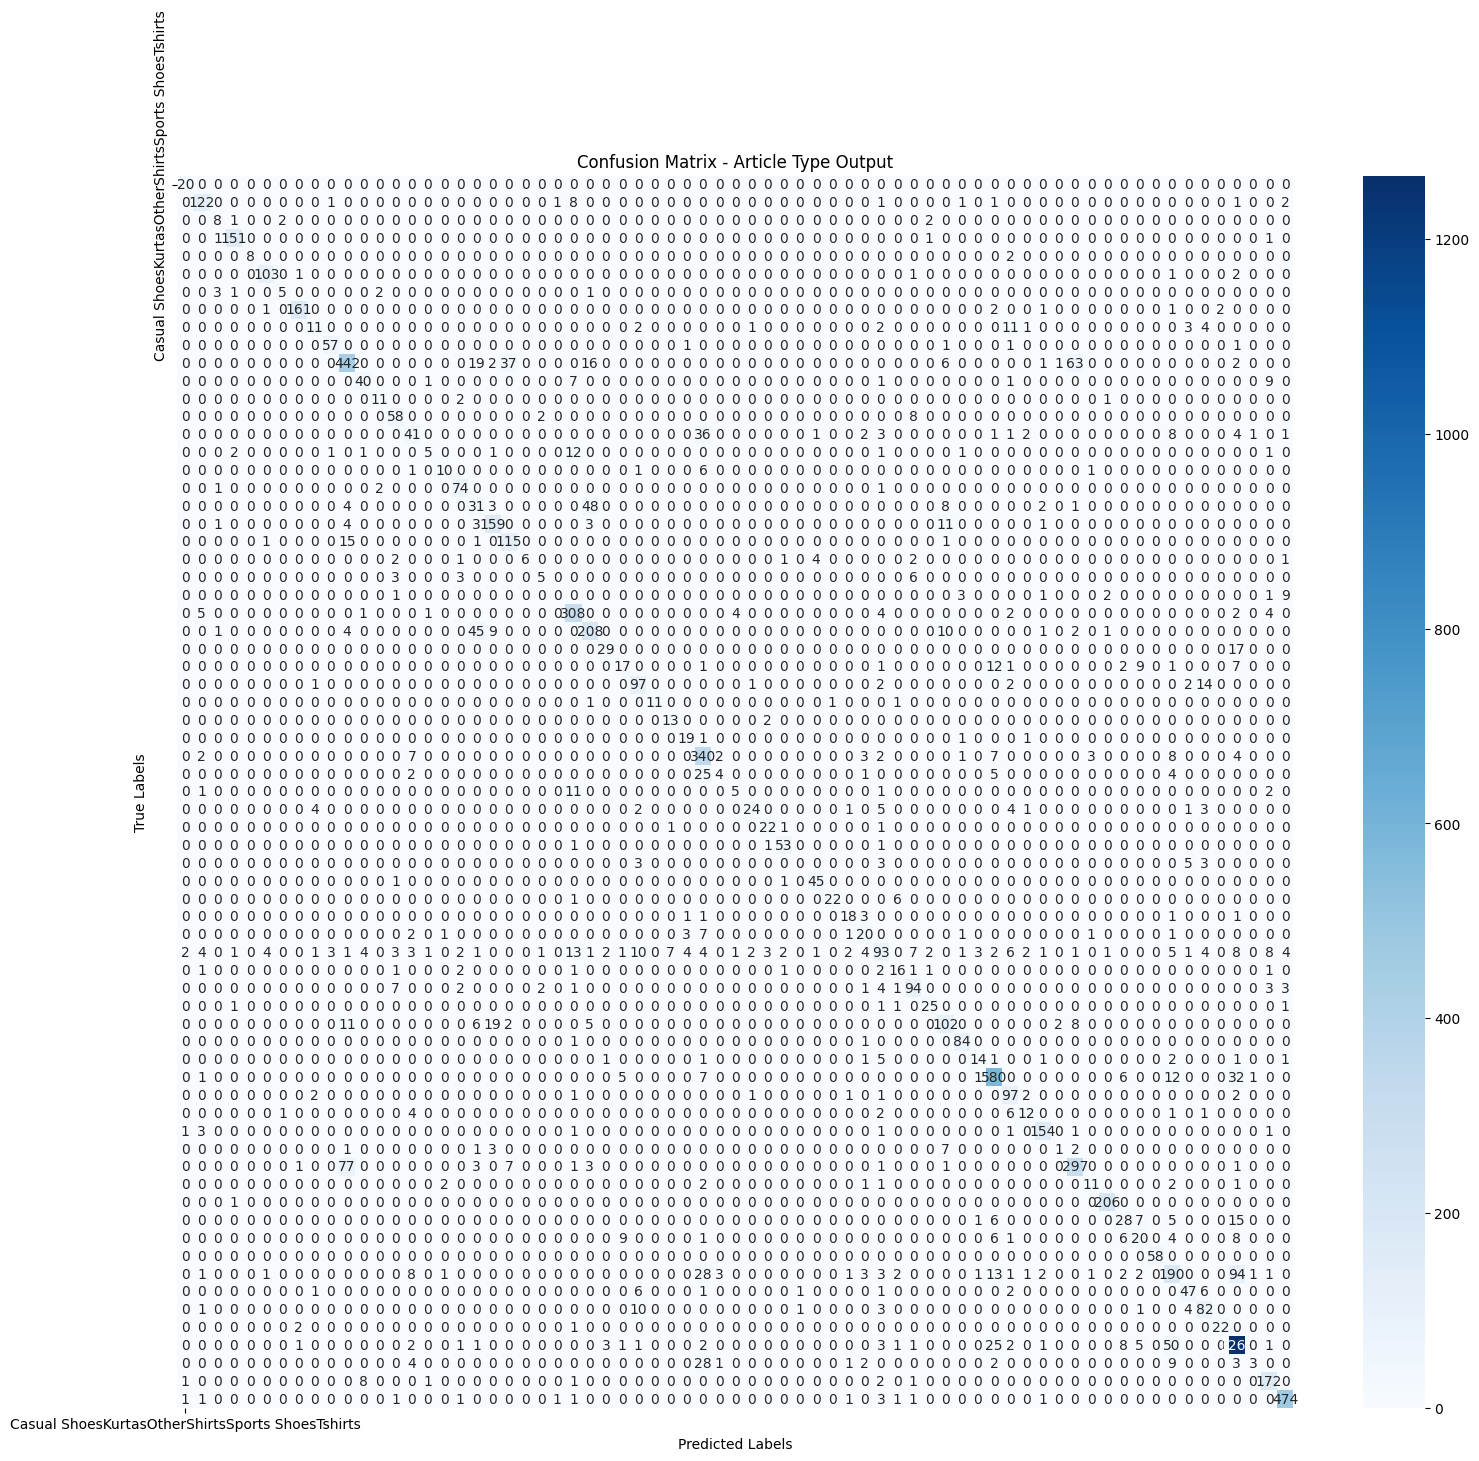

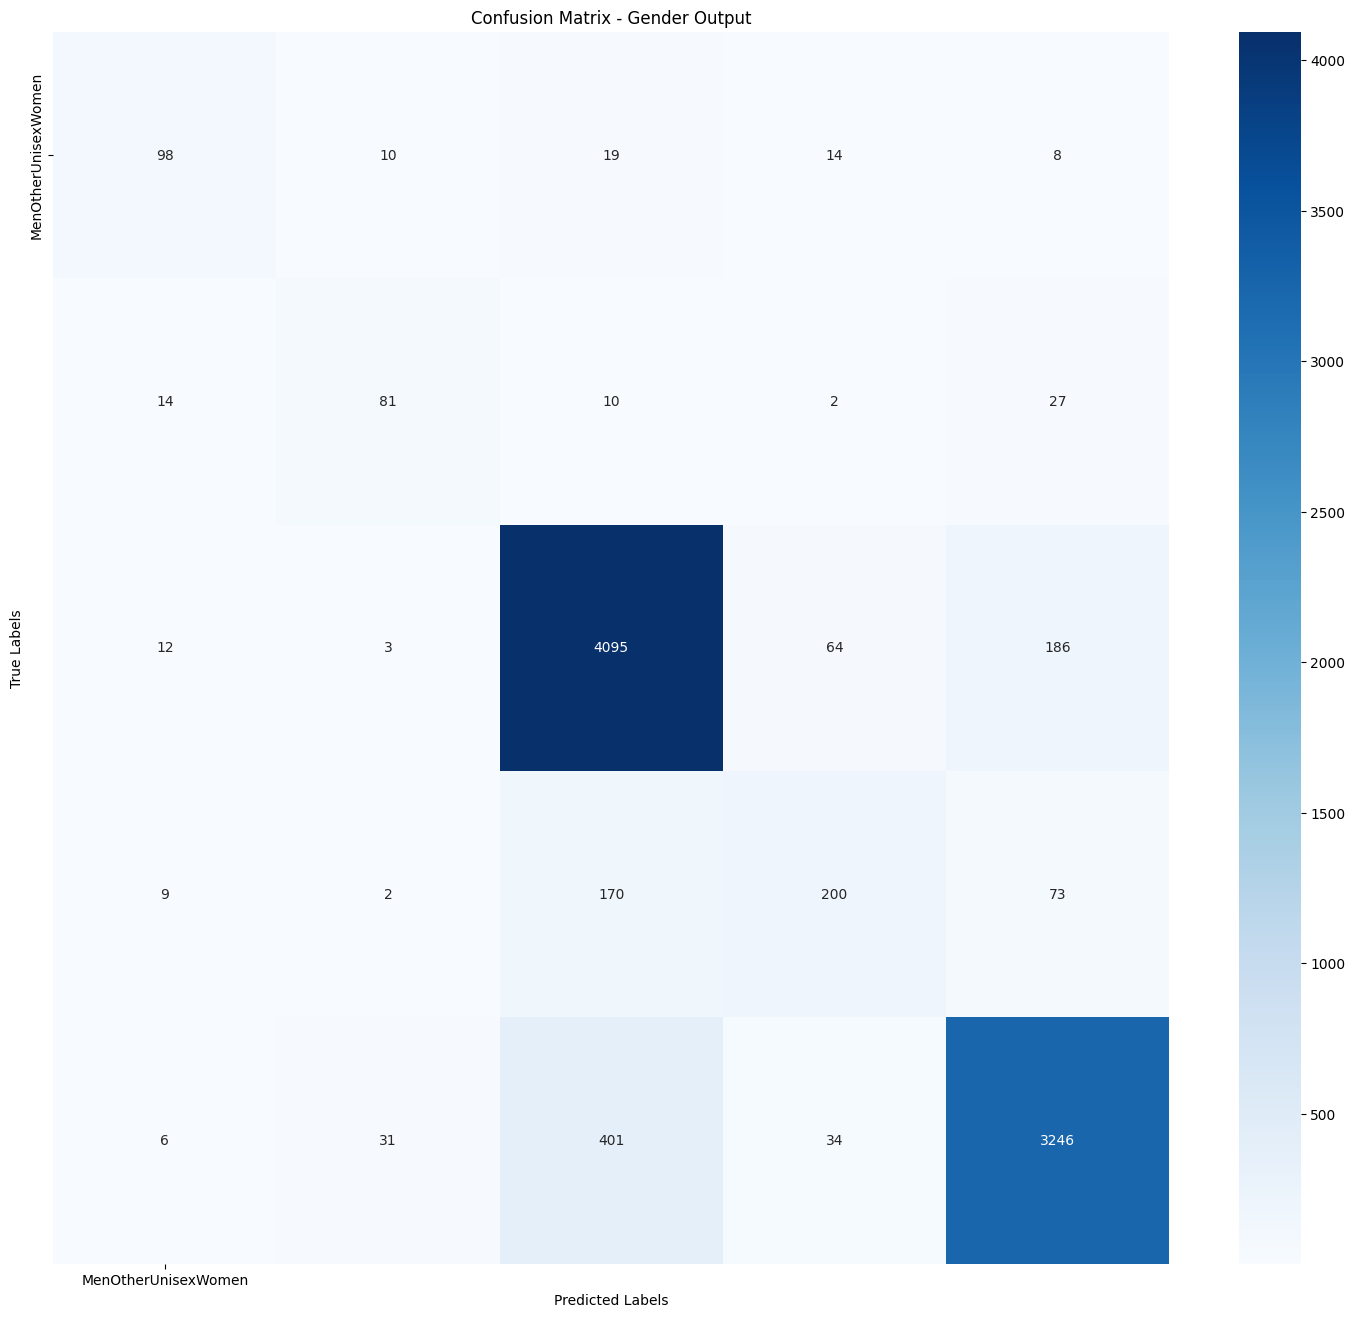

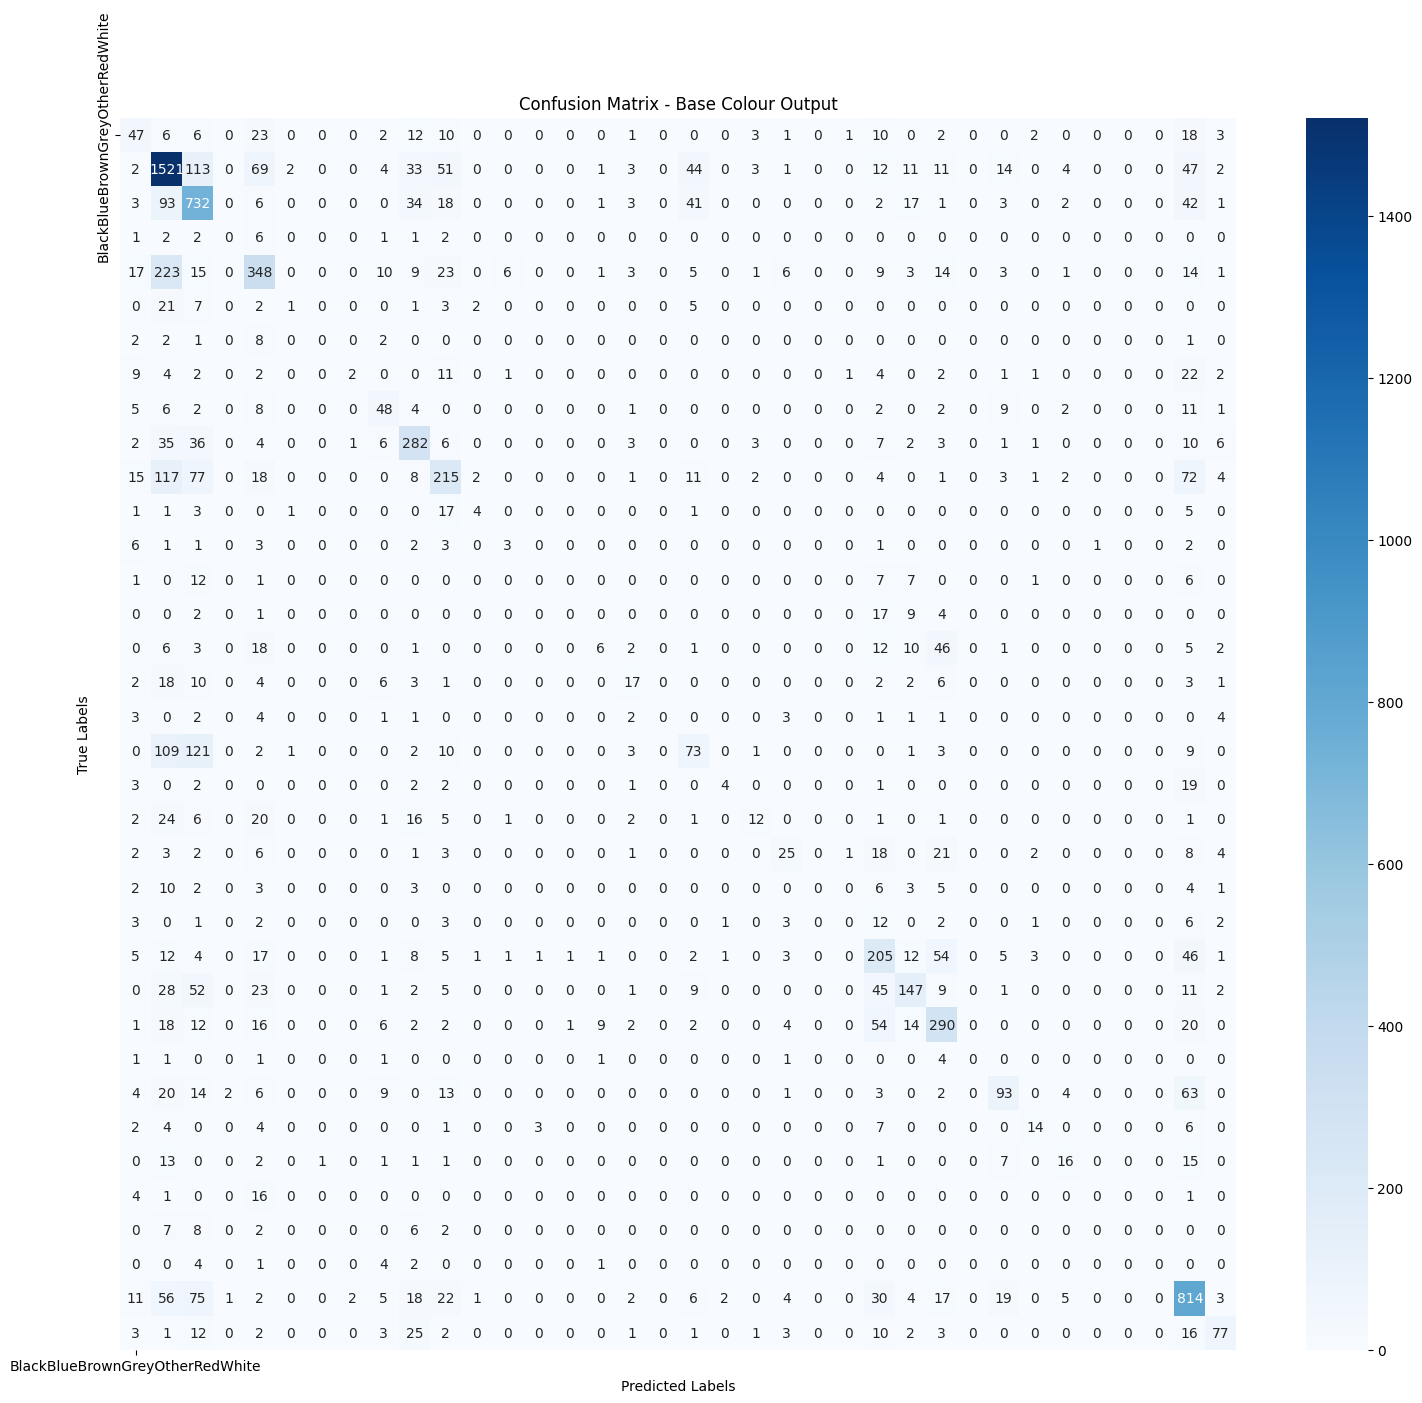

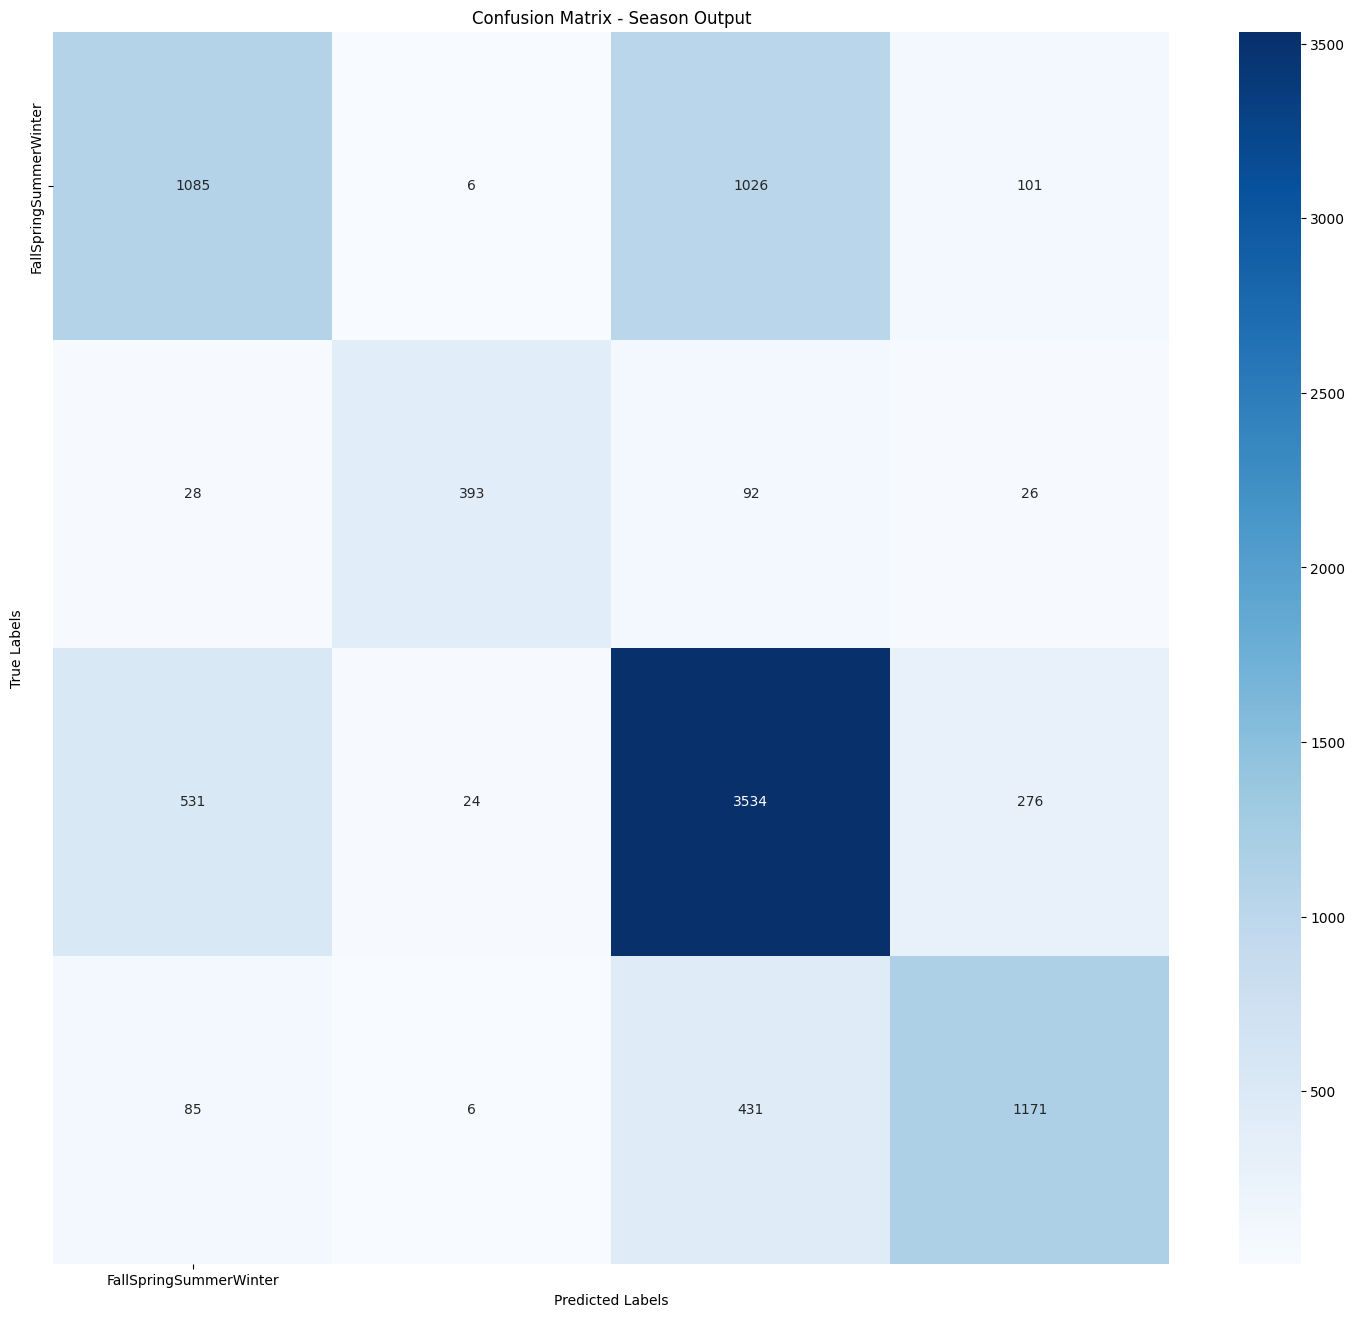

In [27]:
# Plot confusion matrix heatmaps
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(18, 16))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Define class labels for each output (replace with your actual class labels)
classes_article_type = ['Casual Shoes' 'Kurtas' 'Other' 'Shirts' 'Sports Shoes' 'Tshirts']
classes_gender = ['Men' 'Other' 'Unisex' 'Women']
classes_base_colour = ['Black' 'Blue' 'Brown' 'Grey' 'Other' 'Red' 'White']
classes_season = ['Fall' 'Spring' 'Summer' 'Winter']

# Plot confusion matrix heatmaps for each output
plot_confusion_matrix(cm_article_type, classes_article_type, title='Confusion Matrix - Article Type Output')
plot_confusion_matrix(cm_gender, classes_gender, title='Confusion Matrix - Gender Output')
plot_confusion_matrix(cm_base_colour, classes_base_colour, title='Confusion Matrix - Base Colour Output')
plot_confusion_matrix(cm_season, classes_season, title='Confusion Matrix - Season Output')


In [28]:
classes_article_type = ['Casual Shoes' 'Kurtas' 'Other' 'Shirts' 'Sports Shoes' 'Tshirts']
classes_gender = ['Men' 'Other' 'Unisex' 'Women']
classes_base_colour = ['Black' 'Blue' 'Brown' 'Grey' 'Other' 'Red' 'White']
classes_season = ['Fall' 'Spring' 'Summer' 'Winter']


# Example classification report for each output
print("Classification Report - Article Type Output:")
print(classification_report(true_article_type, predictions[0].argmax(axis=1)))

print("\nClassification Report - Gender Output:")
print(classification_report(true_gender, predictions[1].argmax(axis=1)))

print("\nClassification Report - Base Colour Output:")
print(classification_report(true_base_colour, predictions[2].argmax(axis=1)))

print("\nClassification Report - Season Output:")
print(classification_report(true_season, predictions[3].argmax(axis=1)))

Classification Report - Article Type Output:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       0.86      0.88      0.87       138
           2       0.53      0.62      0.57        13
           3       0.96      0.98      0.97       154
           4       1.00      0.80      0.89        10
           5       0.94      0.95      0.94       108
           6       0.62      0.42      0.50        12
           7       0.97      0.96      0.96       168
           8       0.55      0.31      0.40        35
           9       0.92      0.93      0.93        61
          10       0.79      0.75      0.77       589
          11       0.74      0.68      0.71        59
          12       0.73      0.79      0.76        14
          13       0.75      0.85      0.80        68
          14       0.55      0.41      0.47       101
          15       0.56      0.20      0.29        25
          16       0.71      0.53   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
idx=31

(categoryProba, genderProba, colorProba, seasonProba) = model.predict(np.expand_dims(testX[idx], axis=0))

categoryIdx = categoryProba[0].argmax()
genderIdx = genderProba[0].argmax()
colorIdx = colorProba[0].argmax()
seasonIdx = seasonProba[0].argmax()

categoryLabel = articleTypeLB.classes_[categoryIdx]
genderLabel = genderLB.classes_[genderIdx]
colorLabel = baseColourLB.classes_[colorIdx]
seasonLabel = seasonLB.classes_[seasonIdx]

categoryText = "Category: {} ({:.2f}%)".format(categoryLabel, categoryProba[0][categoryIdx] * 100)
genderText = "Gender: {} ({:.2f}%)".format(genderLabel, genderProba[0][genderIdx] * 100)
colorText = "Color: {} ({:.2f}%)".format(colorLabel, colorProba[0][colorIdx] * 100)
seasonText = "Style: {} ({:.2f}%)".format(seasonLabel, seasonProba[0][seasonIdx] * 100)

print(categoryText, '-----', articleTypeLB.classes_[testArticleTypeY[idx].argmax()])
print(genderText, '-----',genderLB.classes_[testGenderY[idx].argmax()])
print(colorText, '-----',baseColourLB.classes_[testBaseColourY[idx].argmax()])
print(seasonText, '-----',seasonLB.classes_[testSeasonY[idx].argmax()])



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Category: Trousers (67.25%) ----- Jeans
Gender: Men (99.89%) ----- Men
Color: Blue (67.76%) ----- Blue
Style: Summer (56.35%) ----- Fall


In [30]:
model.save('fashion_multitask_model.h5')

In [31]:
import pickle

# Save the label binarizers
with open('label_binarizers.pkl', 'wb') as f:
    pickle.dump({
        'articleTypeLB': articleTypeLB,
        'genderLB': genderLB,
        'baseColourLB': baseColourLB,
        'seasonLB': seasonLB
    }, f)


In [32]:
from tensorflow.keras.models import load_model

# Load the saved model
model1 = load_model('fashion_multitask_model.h5')

In [33]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Function to preprocess the input image
def preprocess_image(image):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load the label binarizers
with open('label_binarizers.pkl', 'rb') as f:
    label_binarizers = pickle.load(f)
    articleTypeLB = label_binarizers['articleTypeLB']
    genderLB = label_binarizers['genderLB']
    baseColourLB = label_binarizers['baseColourLB']
    seasonLB = label_binarizers['seasonLB']

# Load the saved model
model1 = load_model('fashion_multitask_model.h5')

# Example index for testing
idx = 10  # Replace with the index of the test image you want to predict

# Preprocess the test image
test_image = preprocess_image(testX[idx])

# Make predictions
(categoryProba, genderProba, colorProba, seasonProba) = model1.predict(test_image)

# Decode predictions
categoryIdx = categoryProba[0].argmax()
genderIdx = genderProba[0].argmax()
colorIdx = colorProba[0].argmax()
seasonIdx = seasonProba[0].argmax()

categoryLabel = articleTypeLB.classes_[categoryIdx]
genderLabel = genderLB.classes_[genderIdx]
colorLabel = baseColourLB.classes_[colorIdx]
seasonLabel = seasonLB.classes_[seasonIdx]

categoryText = "Category: {} ({:.2f}%)".format(categoryLabel, categoryProba[0][categoryIdx] * 100)
genderText = "Gender: {} ({:.2f}%)".format(genderLabel, genderProba[0][genderIdx] * 100)
colorText = "Color: {} ({:.2f}%)".format(colorLabel, colorProba[0][colorIdx] * 100)
seasonText = "Season: {} ({:.2f}%)".format(seasonLabel, seasonProba[0][seasonIdx] * 100)

print(categoryText, '-----', articleTypeLB.classes_[testArticleTypeY[idx].argmax()])
print(genderText, '-----', genderLB.classes_[testGenderY[idx].argmax()])
print(colorText, '-----', baseColourLB.classes_[testBaseColourY[idx].argmax()])
print(seasonText, '-----', seasonLB.classes_[testSeasonY[idx].argmax()])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Category: Kurtas (97.70%) ----- Kurtas
Gender: Women (100.00%) ----- Women
Color: White (45.31%) ----- Beige
Season: Summer (78.83%) ----- Fall
